In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np 

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input, models, layers, optimizers, metrics
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import VGG16



In [2]:
b_size = 5
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip = True, # 수평 대칭 이미지를 50%확률로 만듬
                                  width_shift_range = 0.1, # 전체 크기의 10% 범위에서 좌우로 이동
                                  height_shift_range = 0.1,
                                  fill_mode = 'nearest')

In [3]:
train_generator = train_datagen.flow_from_directory('train',target_size=(150,150),
                                                    batch_size=b_size, class_mode='binary')

Found 160 images belonging to 2 classes.


In [4]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory('test',target_size=(150,150),
                                                    batch_size=b_size, class_mode='binary')

Found 120 images belonging to 2 classes.


In [5]:
transfer_model = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))
transfer_model.trainable = False
transfer_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [7]:
finetune_model = Sequential()
finetune_model.add(transfer_model)
finetune_model.add(Flatten())
finetune_model.add(Dense(64, activation='relu'))
finetune_model.add(Dense(2, activation='softmax'))
finetune_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                524352    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 15,239,170
Trainable params: 524,482
Non-trainable params: 14,714,688
_________________________________________________________________


In [9]:
finetune_model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizers.Adam(learning_rate=0.0002),\
              metrics=['accuracy'])

steps_train = len(train_generator)
steps_test = len(test_generator)

Epoch 1/20
32/32 [==============================] - 15s 469ms/step - loss: 0.6940 - accuracy: 0.5938 - val_loss: 0.4933 - val_accuracy: 0.8083
Epoch 2/20
32/32 [==============================] - 15s 455ms/step - loss: 0.3926 - accuracy: 0.8562 - val_loss: 0.3730 - val_accuracy: 0.8667
Epoch 3/20
32/32 [==============================] - 15s 462ms/step - loss: 0.3180 - accuracy: 0.9062 - val_loss: 0.3702 - val_accuracy: 0.8417
Epoch 4/20
32/32 [==============================] - 14s 452ms/step - loss: 0.2574 - accuracy: 0.9312 - val_loss: 0.2576 - val_accuracy: 0.9250
Epoch 5/20
32/32 [==============================] - 14s 453ms/step - loss: 0.2546 - accuracy: 0.9125 - val_loss: 0.2743 - val_accuracy: 0.8833
Epoch 6/20
32/32 [==============================] - 15s 469ms/step - loss: 0.2031 - accuracy: 0.9187 - val_loss: 0.1975 - val_accuracy: 0.9417
Epoch 7/20
32/32 [==============================] - 16s 494ms/step - loss: 0.1677 - accuracy: 0.9500 - val_loss: 0.1758 - val_accuracy: 0.9333

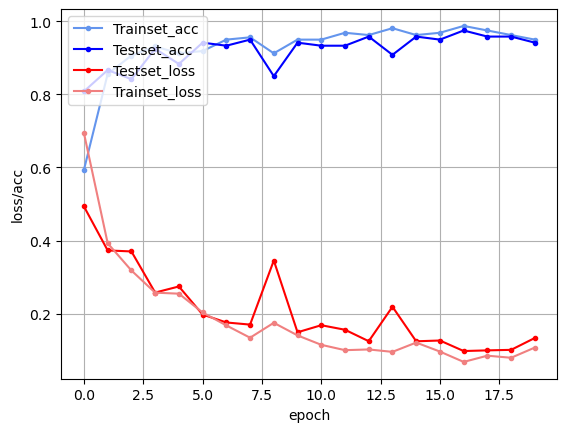

In [10]:
history = finetune_model.fit(
       train_generator,
       steps_per_epoch=steps_train,
       epochs=20,
       validation_data=test_generator,
       validation_steps=steps_test )

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, acc, marker='.', c='cornflowerblue', label='Trainset_acc')
plt.plot(x_len, val_acc, marker='.', c='blue', label='Testset_acc')
plt.plot(x_len, y_vloss, marker='.', c='red', label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c='lightcoral', label='Trainset_loss')

plt.legend(loc='upper left')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss/acc')
plt.show()